In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from pylab import rcParams

from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

plt.style.use("cyberpunk")
rcParams['figure.figsize'] = 20, 10

In [128]:
sales_of_company_x = pd.read_csv("../monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../daily-total-female-births-in-cal.csv")

# Prediction functions

In [129]:
def predict_ma(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

def predict_wma(series, n, weights, n_pred):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    wma = wma.tolist()
    for _ in range (n_pred):
        wma.append((wma[-n:] * weights).sum() / weights.sum()) 
    return wma

def predict_ema(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)


def predict_tse(series, slen, alpha, beta, gamma, n_preds):
    
    def initial_trend(series, season_len):
        return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len
    
    def initial_seasonal_components(series, slen):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(series)/slen)
        # compute season averages
        for j in range(n_seasons):
            season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
        # compute initial values
        for i in range(slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


def predict_dema(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)
    
    return result 

In [130]:
# Score function
def mse_cv_tse(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    train_ = np.array(train)
    
    for train_split, test_split in split.split(train_):
        X_train, X_test = train_[train_split], train_[test_split]
        result = predict_tse(X_train, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        
        error = mean_squared_error(predictions, X_test)
        errors.append(error)

    return np.mean(np.array(errors))


def mse_cv_wma(X):
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    train_ = np.array(train)
    for train_split, test_split in split.split(train_):
        X_train, X_test = train_[train_split], train_[test_split]
        result = predict_wma(X_train, wma_N, X, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, X_test)
        errors.append(error)

    return np.mean(np.array(errors))


def mse_cv_dema(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    train_ = np.array(train)
    
    for train_split, test_split in split.split(train_):
        X_train, X_test = train_[train_split], train_[test_split]
        result = predict_dema(X_train, alpha, beta, len(X_test))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, X_test)
        errors.append(error)

    return np.mean(np.array(errors))


def mse_wma(X):
    result = predict_wma(train, 7, X, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error


def mse_dema(X):
    alpha, beta = X
    result = predict_dema(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error


def plot_tse(train_, true_, alpha, beta, gamma, n_preds=24):
    tse = predict_tse(train_, 12, alpha, beta, gamma, n_preds)
    plt.plot(true_, label='original')
    plt.plot(tse, linewidth='1', label='TSE')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

    
def plot_wma(train_, true_, n, weights, n_preds=12):
    wma = predict_wma(train_, n, weights, n_preds)
    plt.plot(true_, label='original')
    plt.plot(wma, linewidth='4', label='WMA')
    plt.title(f"N={n} weights: " + str(weights))
    plt.legend()

    
def plot_dema(train_, true_, alpha, beta, n_preds=12):
    dema = predict_dema(train_, alpha, beta, n_preds)
    plt.plot(true_, label='original')
    plt.plot(dema, linewidth='1', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

# Sales of company
## Not stationary

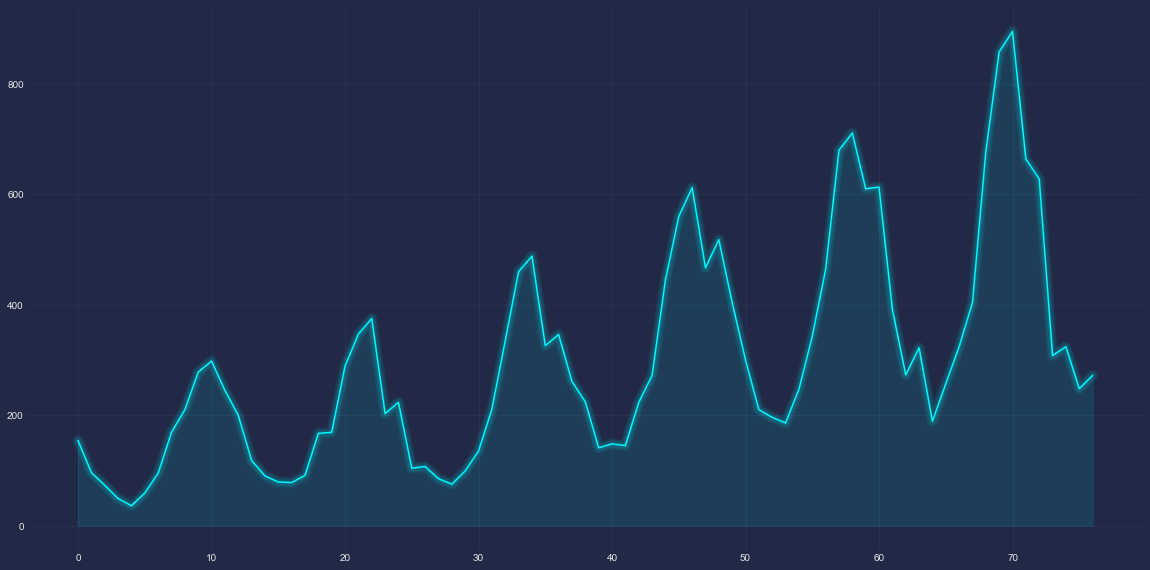

In [131]:
series = sales_of_company_x['Count'].tolist()
plt.plot(series)
mplcyberpunk.add_glow_effects()
plt.show()

This obviously has a trend and seasonality. That's why I will use Holt-Winters.

In [132]:
train, val = series[:60], series[60:]
opt = minimize(mse_cv_tse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [133]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4520.439010459898
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.45519152e-03, -1.81898940e-04, -1.07048982e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 18
   status: 0
  success: True
        x: array([0.51046004, 0.31318026, 1.        ])


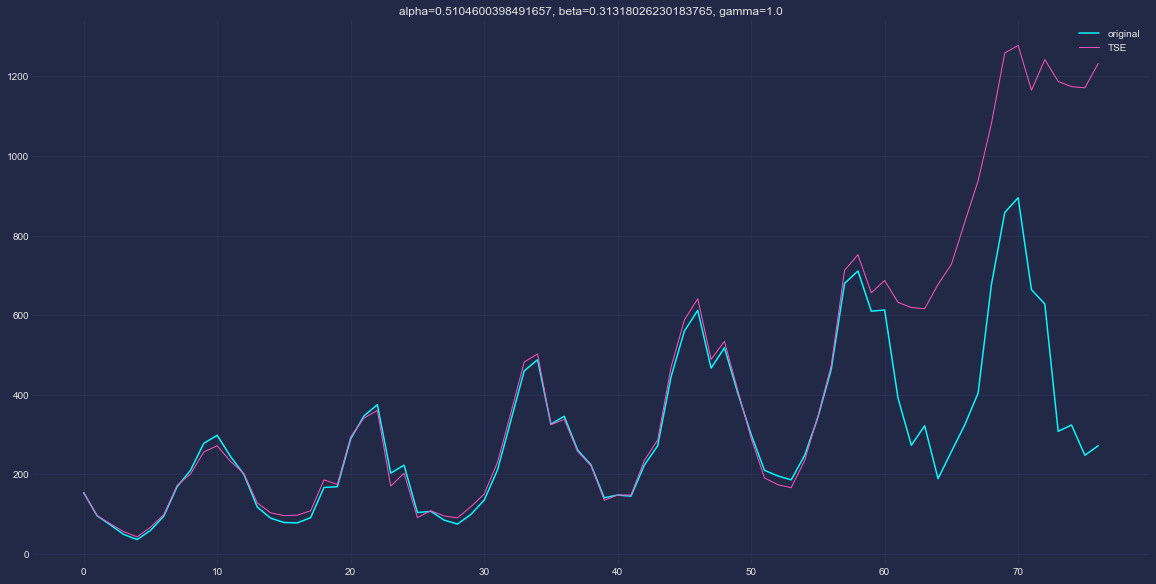

In [134]:
plot_tse(train, series, alpha_opt, beta_opt, gamma_opt, len(val))

Not good looking. Overfitting. Try to manually choose. 

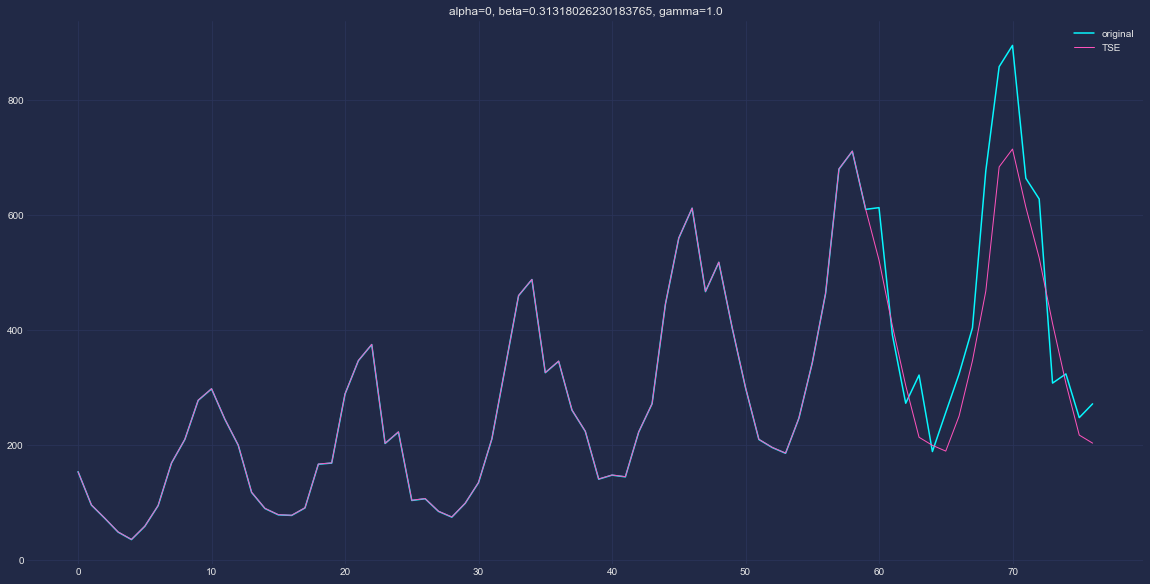

In [135]:
plot_tse(train, series, 0, beta_opt, gamma_opt, len(val))

Seems much better. But digits say opposite.

In [136]:
mse_cv_tse([0, beta_opt, gamma_opt])

9783.71111111108

In [137]:
mse_cv_tse([alpha_opt, beta_opt, gamma_opt])

4520.439010459898

I say it is because of overfitting.

## Stationary

In [138]:
# stationary it
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
series = series[2:] - series[:-2]

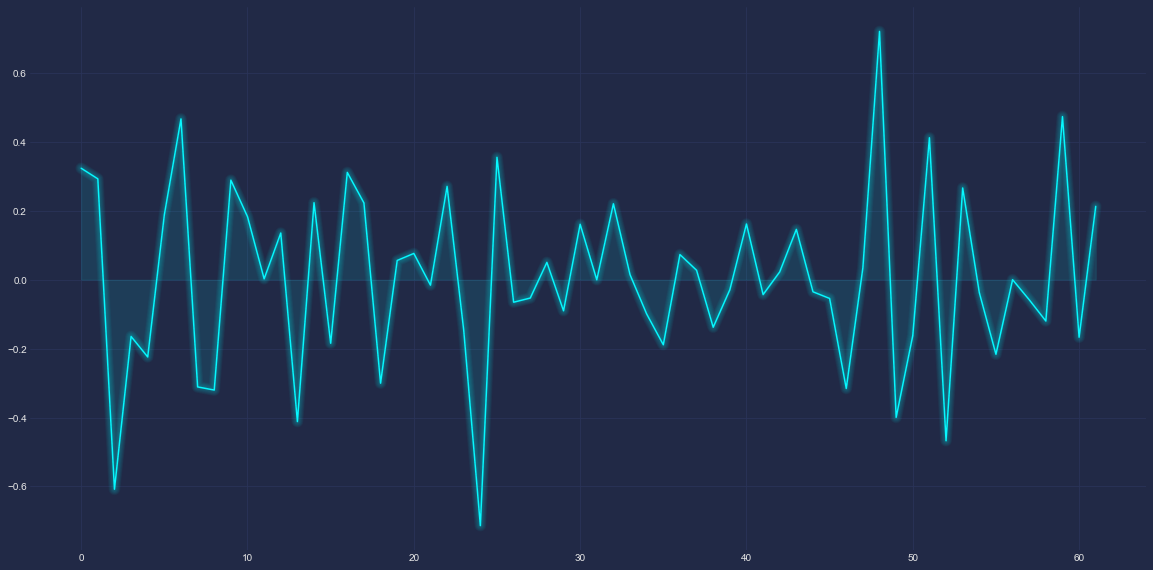

In [139]:
plt.plot(series)
mplcyberpunk.add_glow_effects()
plt.show()

**Because there is no trend or seasonality I will consider to use WMA for predictions (I think it performance better, that EMA or MA).**

In [140]:
wma_N = 8
train, val = series[:60], series[60:]
x0 = [1 for i in range(wma_N)]
bounds = [(1,1000) for i in range(wma_N)]
bounds = tuple(bounds)

opt = minimize(mse_cv_wma, x0=x0, method="L-BFGS-B", 
               bounds = bounds)
weights = opt.x
weights

array([51.51161516,  1.        ,  1.        ,  2.50363665, 60.76519083,
        1.        ,  1.        , 32.6105019 ])

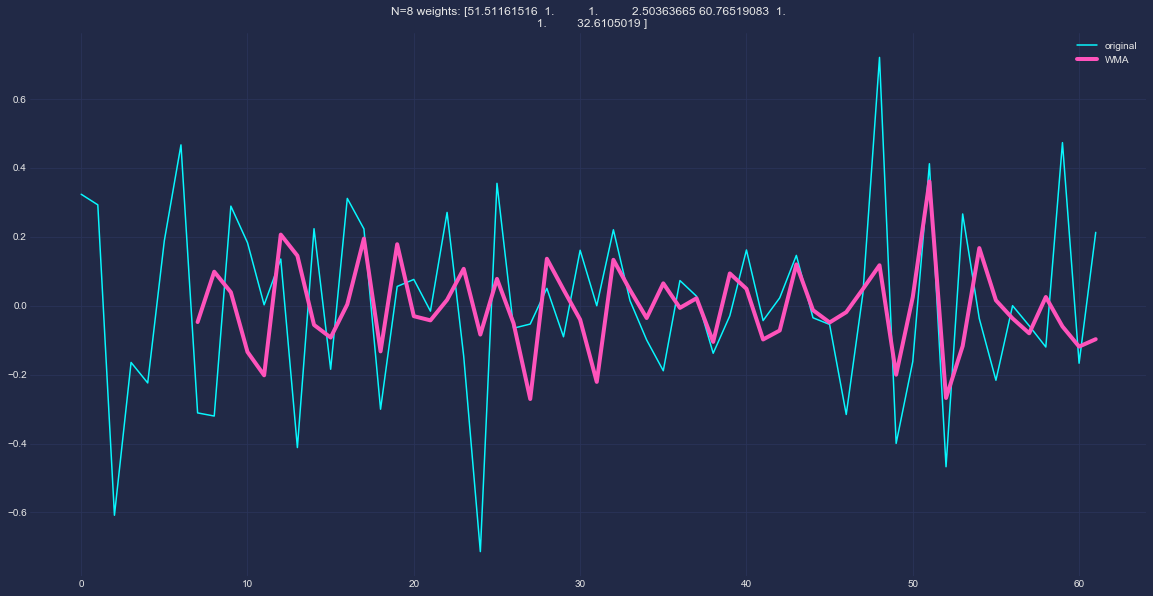

In [141]:
plot_wma(train, series, wma_N, weights, len(val))

I thought it was overfitted because there was a mistake CV method provided by the teacher's notebook. Before I found it, I tried to fit WMA without cross-validation. The result is below. Then I figured out that something is wrong. I located the mistake and fixed it.

In [142]:
train, test, val = series[:50], series[50:68], series[68:]

In [143]:
opt = minimize(mse_wma, x0=[1,1,1,1,1,1,1], method="L-BFGS-B", 
               bounds = ((1, 250), (1, 250), (1, 250), (1, 250), (1, 250), (1, 250), (1, 250)))

In [144]:
weights = opt.x

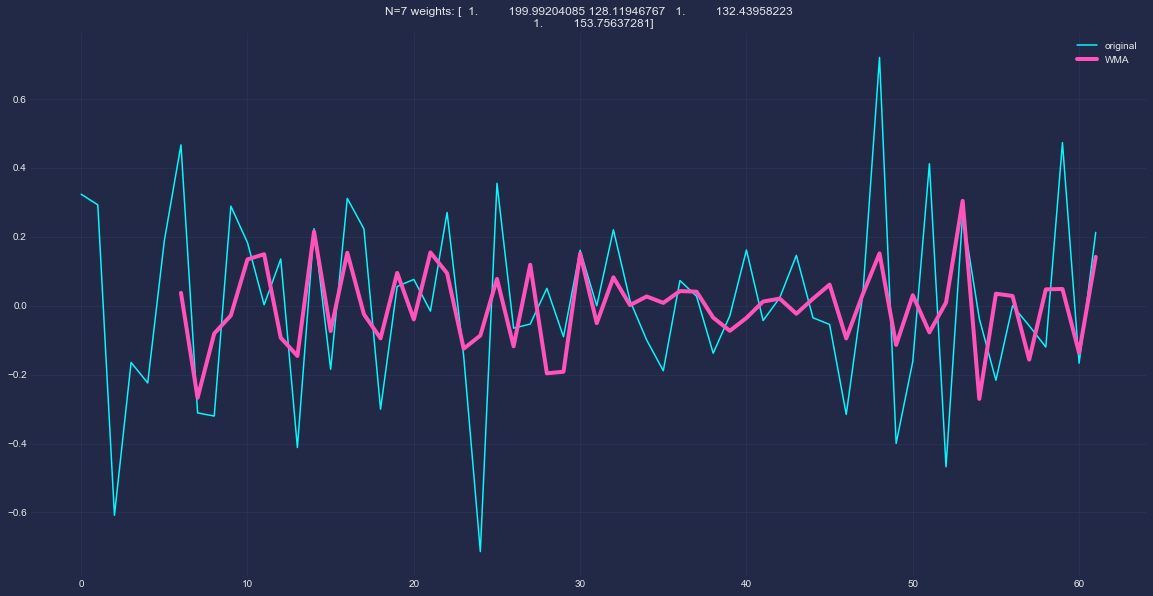

In [145]:
plot_wma(series[:68], series, 7, weights, len(val))

# Robberies in Boston
## Not stationary

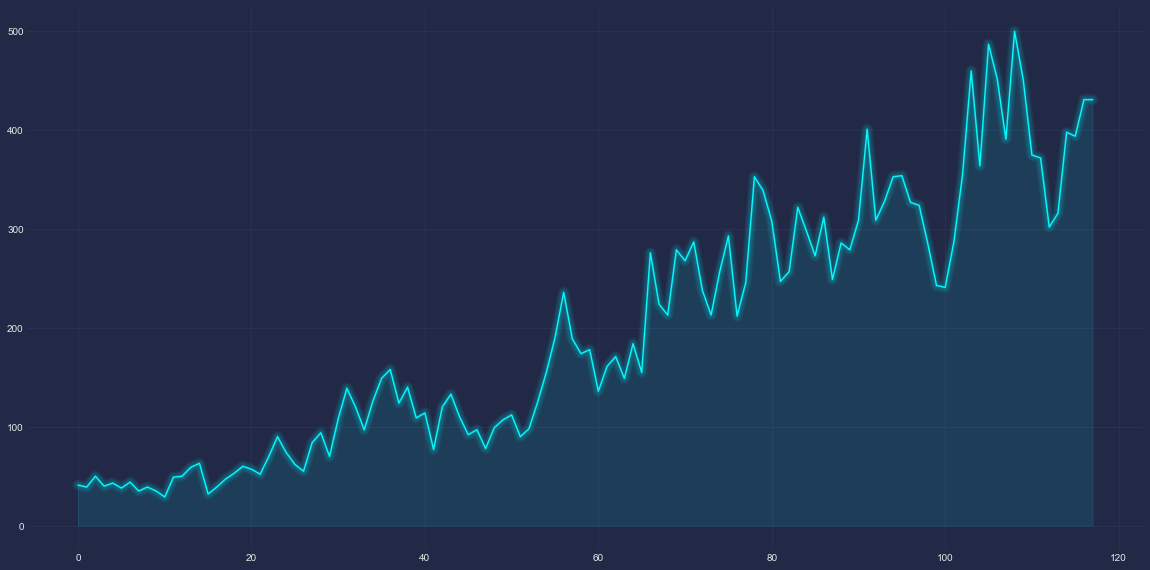

In [146]:
series = robberies_in_boston['Count'].tolist()
plt.plot(series)
mplcyberpunk.add_glow_effects()
plt.show()

We have a trend, so I will use Double Exponential Moving Average.

In [147]:
train, val = series[:100], series[100:]
opt = minimize(mse_cv_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [148]:
alpha, beta = opt.x

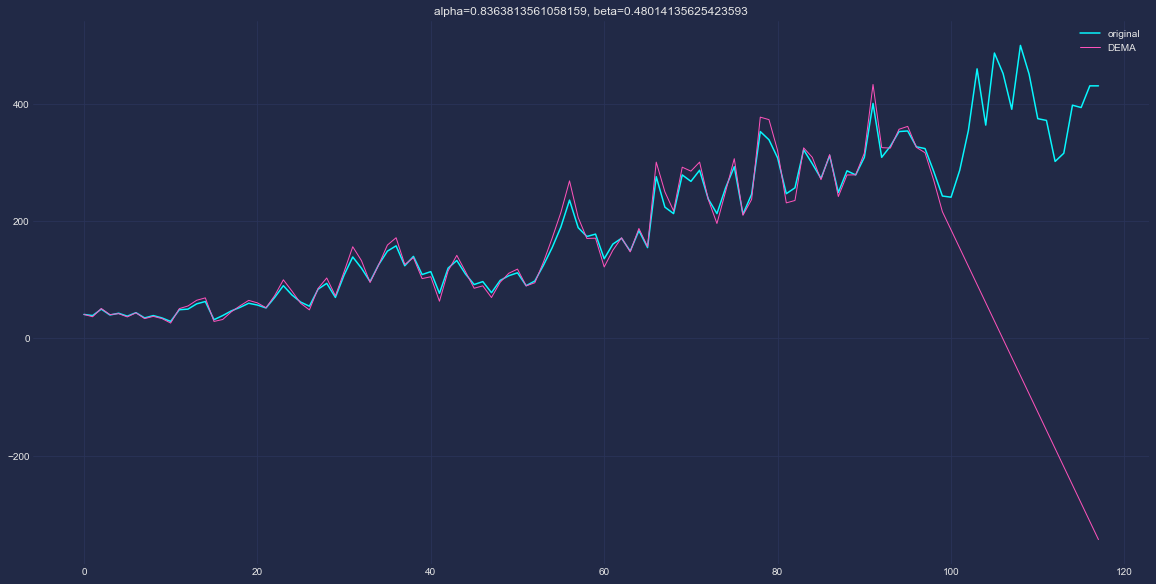

In [149]:
plot_dema(train, series, alpha, beta, len(val))

Not good.

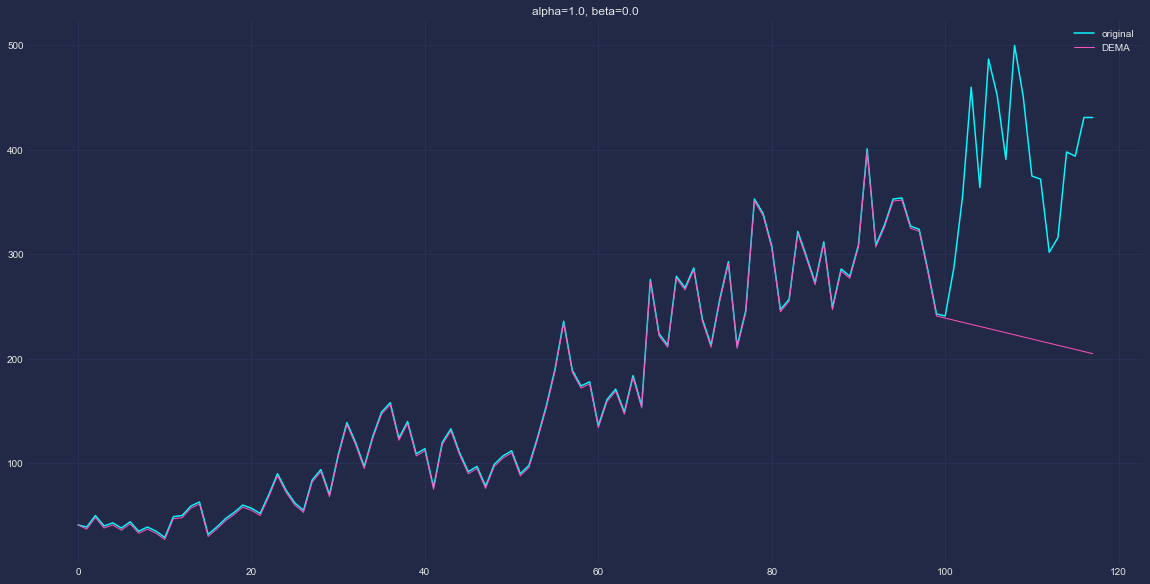

In [150]:
train, test, val = series[:80], series[80:100], series[100:]
opt = minimize(mse_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha, beta = opt.x
plot_dema(series[:100], series, alpha, beta, len(val))

Hm. I don't get that. Do I made a mistake?

## Stationary

In [151]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]

In [152]:
wma_N = 12
train, val = series[:90], series[90:]
x0 = [1 for i in range(wma_N)]
bounds = [(1,1000) for i in range(wma_N)]
bounds = tuple(bounds)

opt = minimize(mse_cv_wma, x0=x0, method="L-BFGS-B", 
               bounds = bounds)
weights = opt.x
weights

array([49.70852719,  1.98957809,  1.        ,  1.        , 48.86898113,
        1.        ,  1.        ,  1.        ,  1.        , 84.96255845,
        1.        ,  1.        ])

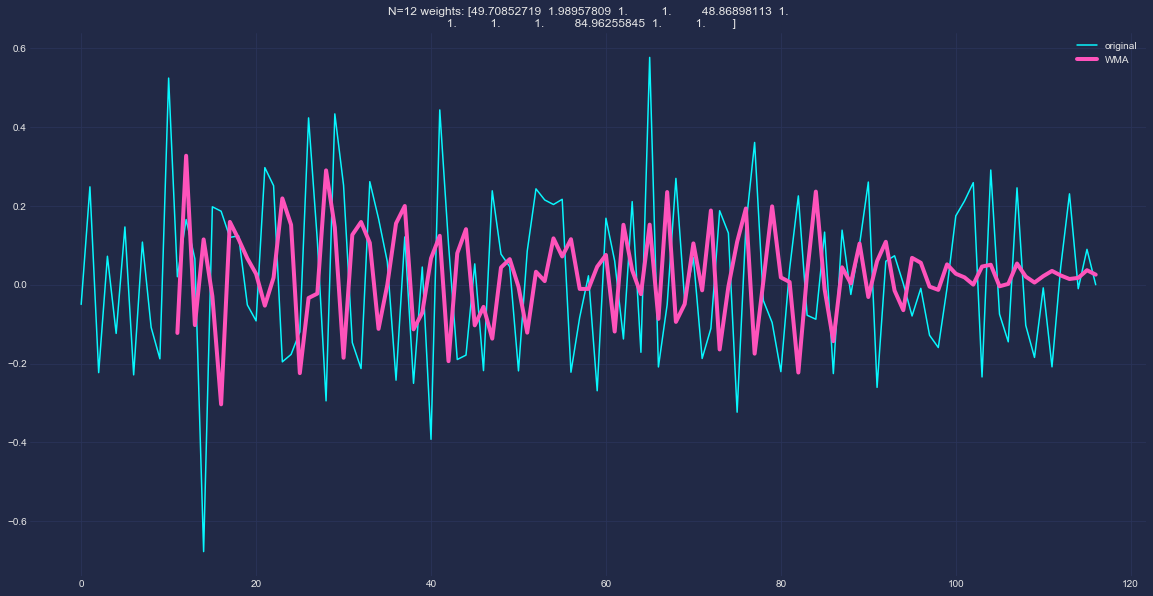

In [153]:
plot_wma(train, series, wma_N, weights, len(val))

# Airlines passengers
## not stationary

In [155]:
series = airlines_passengers['Count']

A trend + seasonality.

In [156]:
index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]
opt = minimize(mse_cv_tse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

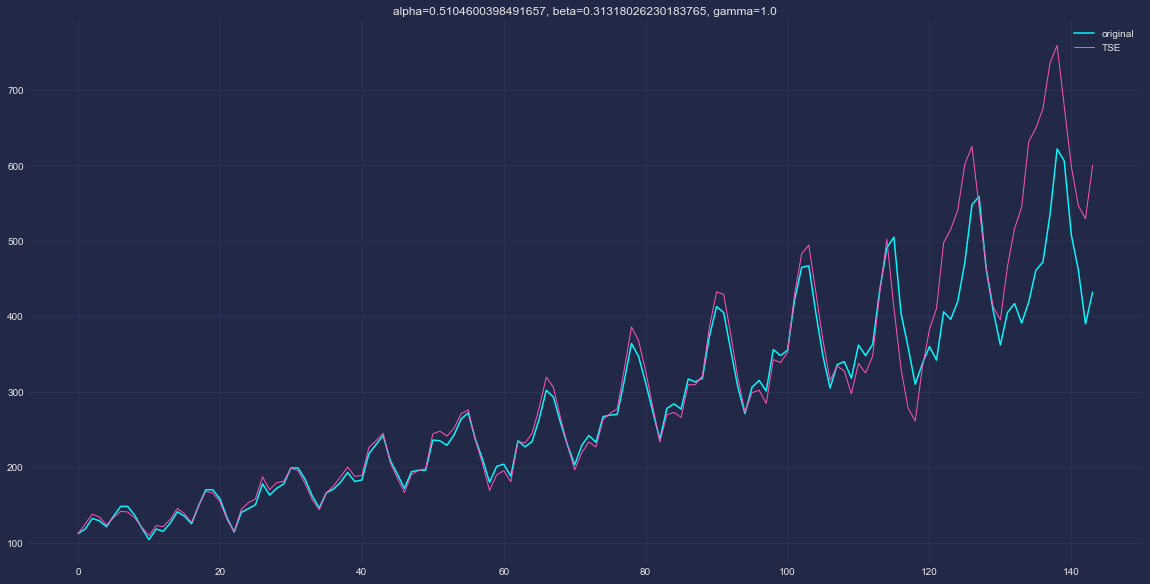

In [157]:
plot_tse(train, series, alpha_opt, beta_opt, gamma_opt, len(val))

## Stationary

In [158]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

In [172]:
wma_N = 3

index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]

x0 = [1 for i in range(wma_N)]
bounds = [(1,1000) for i in range(wma_N)]
bounds = tuple(bounds)

opt = minimize(mse_cv_wma, x0=x0, method="L-BFGS-B", 
               bounds = bounds)
weights = opt.x
weights

array([1.        , 4.99245827, 1.64248322])

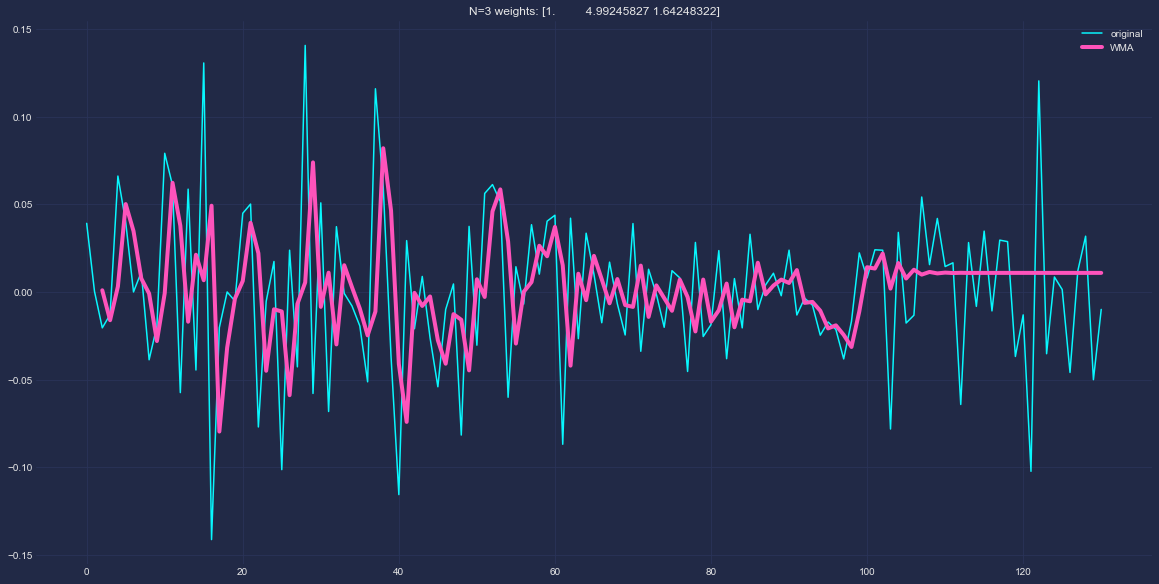

In [173]:
plot_wma(train, series, wma_N, weights, len(val))

# Mean monthly temperature
## Not stationary

In [177]:
series = mean_monthly_temp['Deg']

Seasonality without a trend. Still, I will use TSE. Because only it able to handle seasonality.

In [178]:
index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]
opt = minimize(mse_cv_tse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

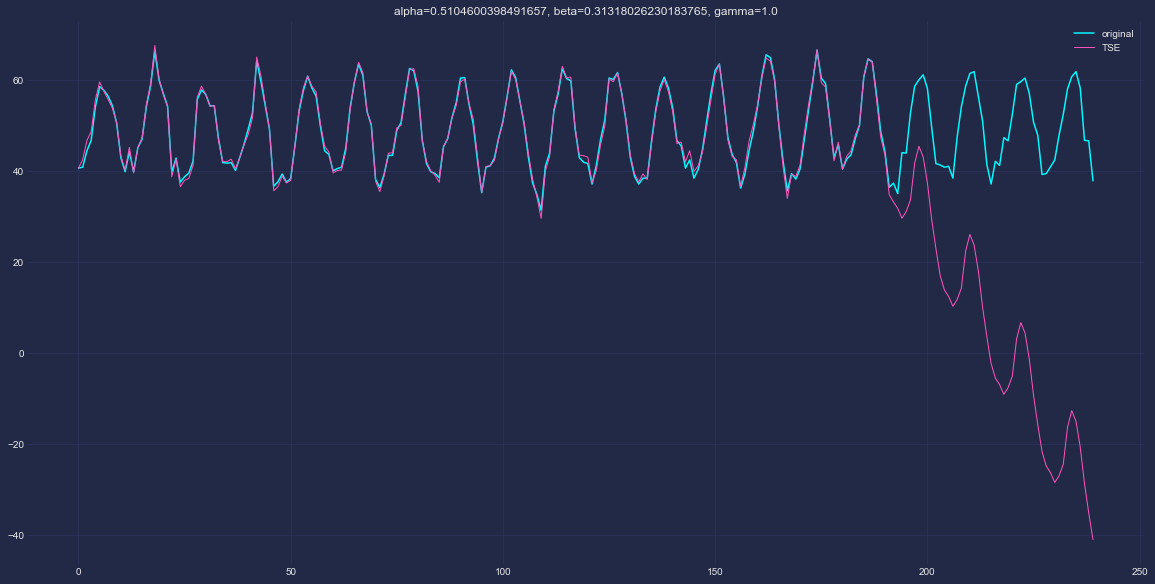

In [179]:
plot_tse(train, series, alpha_opt, beta_opt, gamma_opt, len(val))

I'm going down
I'm going, down, down, down
Down, down
Yes, I'm going down, yes
I'm going down, down, down
Down, down

## Stationary

In [181]:
series = boxcox(series, 0)
series = series[12:] - series[:-12]

In [192]:
wma_N = 6

index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]

x0 = [1 for i in range(wma_N)]
bounds = [(1,1000) for i in range(wma_N)]
bounds = tuple(bounds)

opt = minimize(mse_cv_wma, x0=x0, method="L-BFGS-B", 
               bounds = bounds)
weights = opt.x
weights

array([6.18232505, 4.8606244 , 1.99672936, 1.        , 1.        ,
       1.        ])

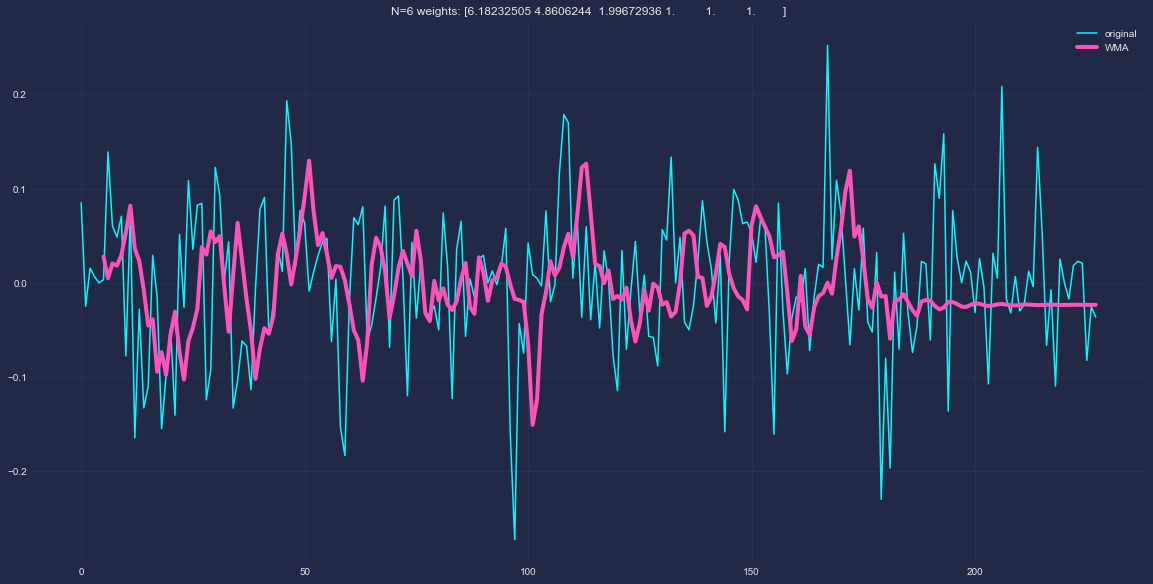

In [193]:
plot_wma(train, series, wma_N, weights, len(val))

# Dowjones closing
# not stationary

In [196]:
series = dowjones_closing['Close']

In [197]:
index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]

opt = minimize(mse_cv_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha, beta = opt.x

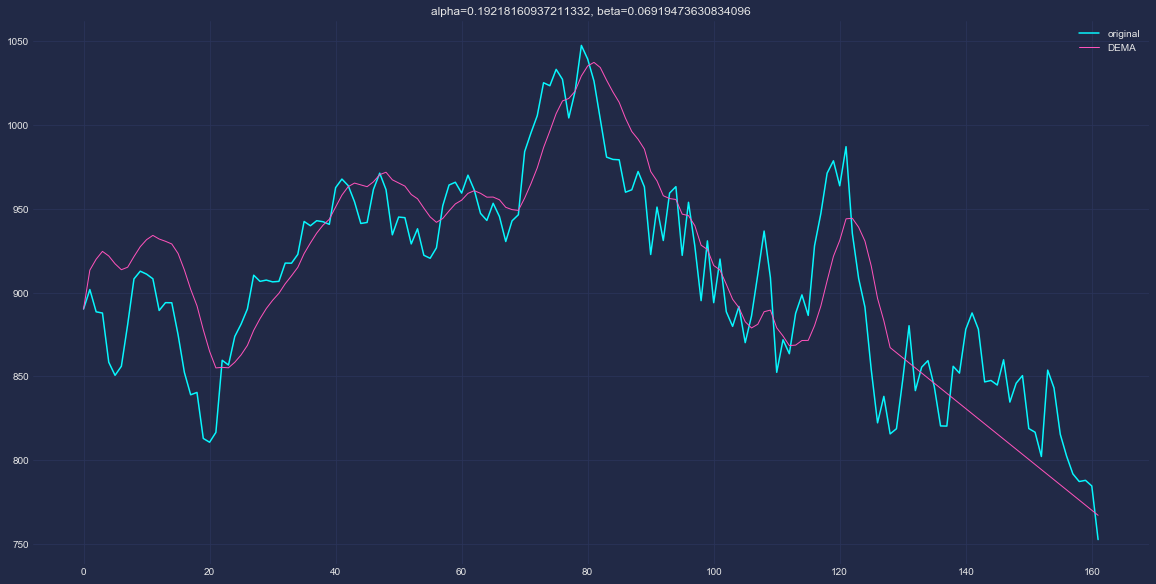

In [198]:
plot_dema(train, series, alpha, beta, len(val))

Not bad actually!
## Stationary

In [200]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]

In [213]:
wma_N = 10

index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]

x0 = [1 for i in range(wma_N)]
bounds = [(1,1000) for i in range(wma_N)]
bounds = tuple(bounds)

opt = minimize(mse_cv_wma, x0=x0, method="L-BFGS-B", 
               bounds = bounds)
weights = opt.x
weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

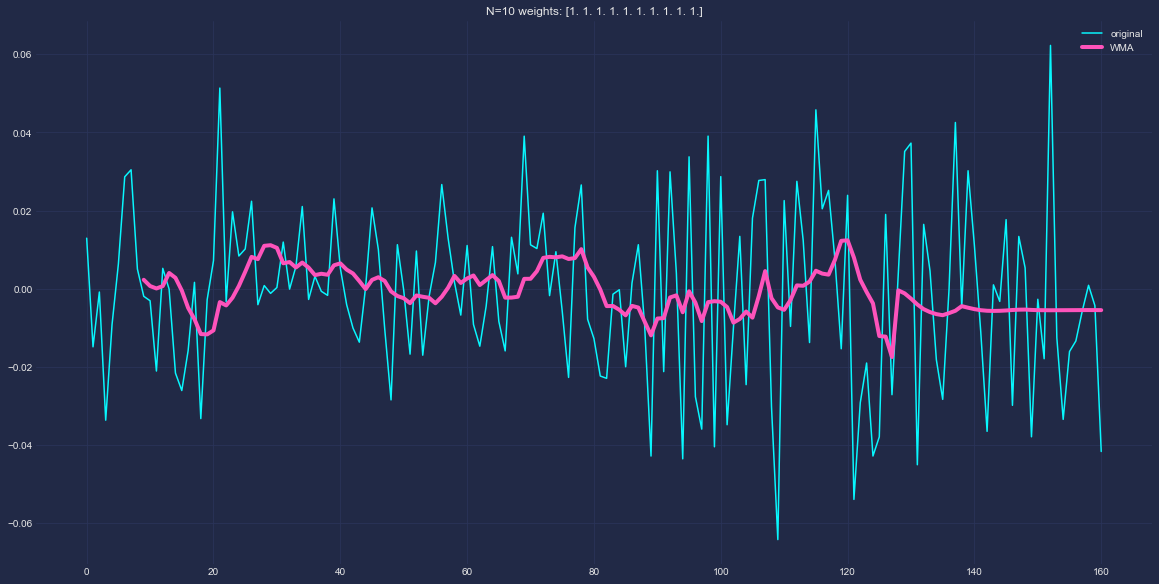

In [214]:
plot_wma(train, series, wma_N, weights, len(val))

Interesting situation, no matter how many lags I take, optimal weights are always equal 1.

# Female births in California
## Stationary

In [217]:
series = female_births['Count']

In [218]:
wma_N = 10

index = len(series)
test_size = 0.2
index = int(index*(1-test_size))
train, val = series[:index], series[index:]

x0 = [1 for i in range(wma_N)]
bounds = [(1,1000) for i in range(wma_N)]
bounds = tuple(bounds)

opt = minimize(mse_cv_wma, x0=x0, method="L-BFGS-B", 
               bounds = bounds)
weights = opt.x
weights

array([ 15.3491604 , 256.34419786,   1.        ,   1.        ,
         1.        , 256.67541594, 405.18458755, 991.10976524,
       220.806946  ,   1.        ])

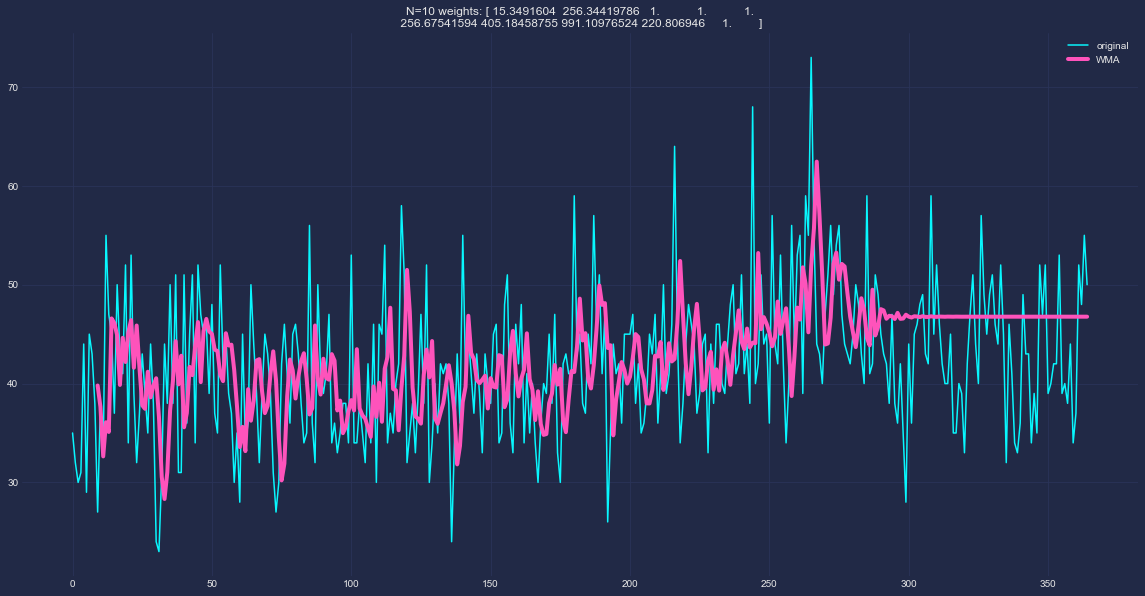

In [219]:
plot_wma(train, series, wma_N, weights, len(val))

# Final thoughts
Most models are pretty bad. Moving average is rarely can be used with success. 